# kickstarter.com data pipeline

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from mlxtend.preprocessing import minmax_scaling

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sqlalchemy import create_engine

np.random.seed(0)

%run functions.ipynb



## ------------------ PART 1: Ingestion and exploratory analysis -----------------

In [1]:
BASE_PATH = r'C:\Users\Ummar Awan/Desktop/MDDD' #Absolute path set
filename = 'ks-projects-201612.csv'

In [3]:

PATH_TO_DATA = f'{BASE_PATH}/{filename}'
# Default encoding is None, but I have observed that it doesn't recognize some characters. Choosing ANSI solves the problem
df_base = pd.read_csv(PATH_TO_DATA, low_memory=False, encoding='ANSI')
# Clean the headers
df_cleaned_headers = clean_df_headers(df_base)
df_cleaned_headers = df_cleaned_headers.rename( columns= {'usd pledged': 'usd_pledged'} )
df_cleaned_headers = df_cleaned_headers.rename( columns= {'goal': 'usd_goal'} )
df_cleaned_headers.head(3)

all cols casted to lowercase and whitespaces stripped ✓


,id,name,category,main_category,currency,deadline,usd_goal,launched,pledged,state,backers,country,usd_pledged,unnamed: 13,unnamed: 14,unnamed: 15,unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN


In [4]:
# The column type is "object", so I have to cast to numeric.
# Some entries are invalid (example: '2016-02-02 00:56:46' instead of a numeric value)
# The option 'coerce' cast any weird entry to NaN
df_cleaned_headers['usd_goal'] = pd.to_numeric(df_cleaned_headers['usd_goal'], errors='coerce')

<AxesSubplot:>

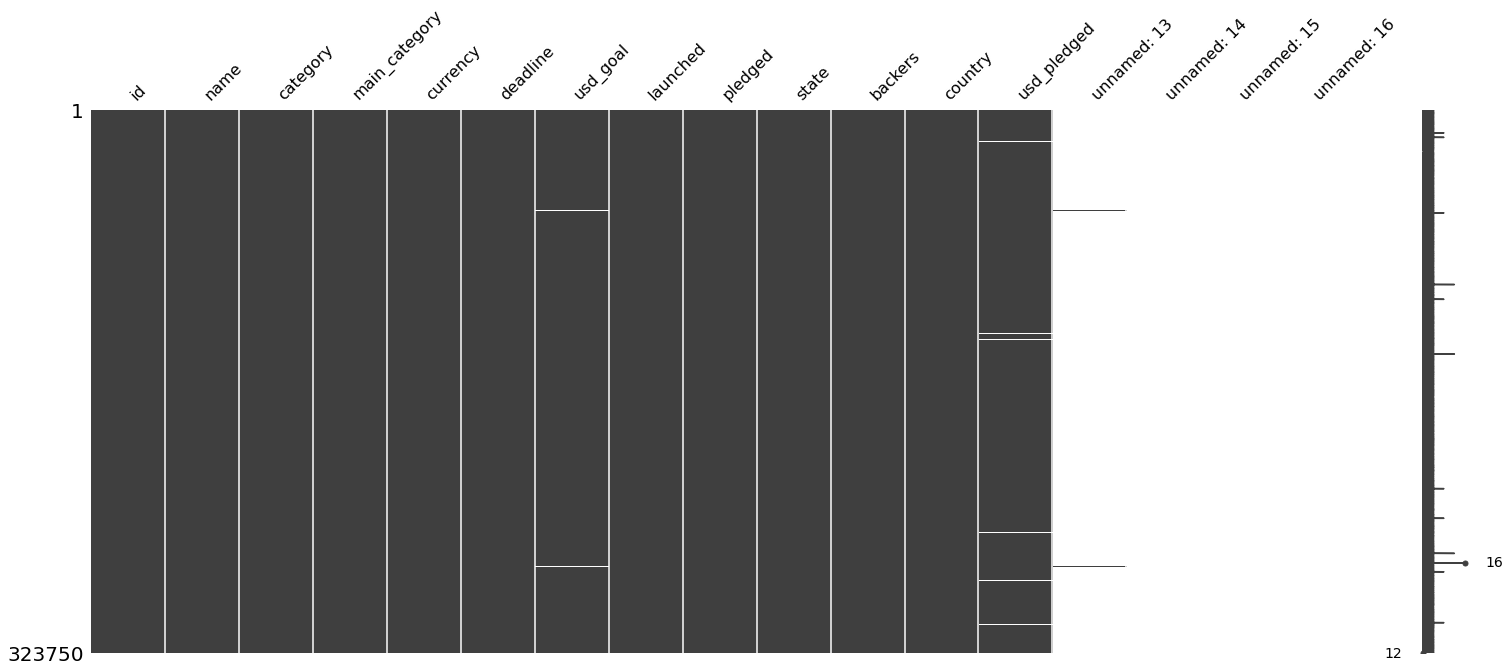

In [5]:
# About the quality of this dataset:
# 1. Contains 4 almost empty cols.
# 2. usd_pledged and usd_goal contain some missing values (NaN)
msno.matrix(df_cleaned_headers)

In [6]:
# Keep only a subset of the dataset (discard empty columns). 
list_required_cols = ['id',
                      'name',
                      'category',
                      'main_category',
                      'currency',
                      'deadline',
                      'usd_goal',
                      'launched',
                      'pledged',
                      'state',
                      'backers',
                      'country',
                      'usd_pledged',
                      
]

df_clean = df_cleaned_headers[list_required_cols]

In [7]:
# The amount of NaN is negligible (at most 4431 rows out of 300k roughly ~1%), so can be safely dropped without loosing too much info
df_clean.isnull().sum()

id                  0
name                4
category            5
main_category       0
currency            0
deadline            0
usd_goal          632
launched            0
pledged             0
state               0
backers             0
country             0
usd_pledged      3790
dtype: int64

In [8]:
print(f'Before dropna: {df_clean.shape}')
df_clean = df_clean.dropna()
print(f'After dropna: {df_clean.shape}')

Before dropna: (323750, 13)
After dropna: (319324, 13)


## ------------------------------ PART 2: Transformations ----------------------------------

In [9]:
# This data presents the typical L-shape; lots of records have a value of zero, very few have large values. 
# Scaling just changes the range of values, it doesnt change the L-shape.
# However, it is still very important for prediction. 
# Example: We have features F1 and F2, to predict target Y. 
# F1 varies between 0 and 9999. 
# F2 varies between 0 and 5. 
# In this situation, F1 provides a much stronger signal, and thus Y varies much more with F1 than F2. 
# To avoid this "over-signal", both F1 and F2 should be scaled to same range (for example. 0-1).

# So, this is exactly what I do here: scale both 'usd_goal' and 'usd_pledged' to be in range (0-1)


df_clean['usd_goal_scaled'] = minmax_scaling(np.array(df_clean['usd_goal']), columns = [0])
df_clean['usd_pledged_scaled'] = minmax_scaling(np.array(df_clean['usd_pledged']), columns = [0])

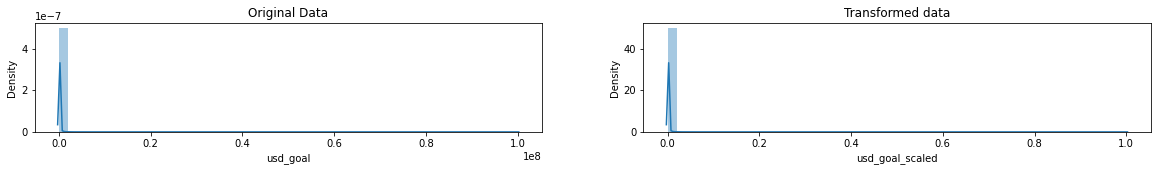

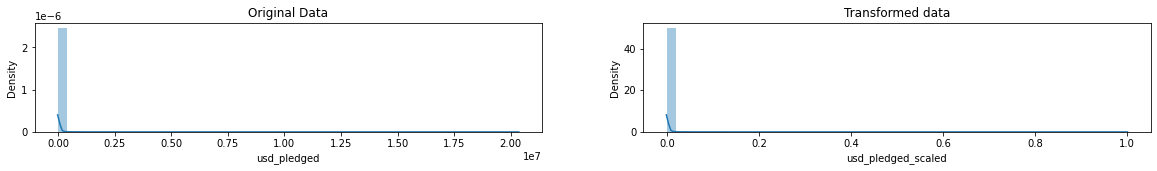

In [10]:
plot_comparison(df_clean['usd_goal'],df_clean['usd_goal_scaled'])
plot_comparison(df_clean['usd_pledged'],df_clean['usd_pledged_scaled'])

In [11]:
# Additionally, some ML models require that the features follow a normal distribution (or "close enough")
# Therefore, the features following a L-shape need to be normalized with for example a yeojohnson transformation.
# After normalizing the scaled data, the scaled columns can just be discarded 

df_clean['usd_goal_normalized'] = stats.yeojohnson(df_clean['usd_goal_scaled'])[0]
#df_clean = df_clean.drop('usd_goal_scaled', axis = 'columns')

df_clean['usd_pledged_normalized'] = stats.yeojohnson(df_clean['usd_pledged_scaled'])[0]
#df_clean = df_clean.drop('usd_pledged_scaled', axis = 'columns')


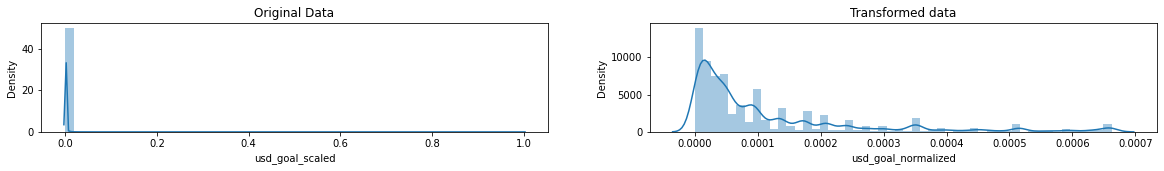

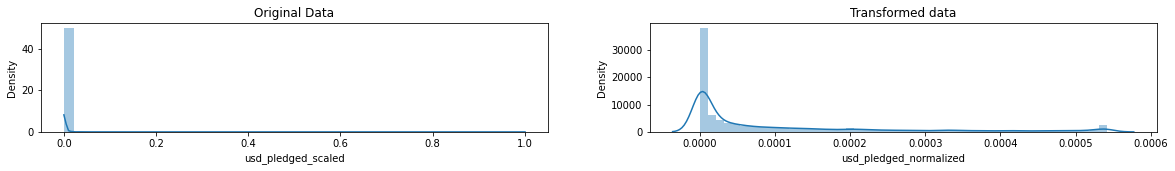

In [12]:
plot_comparison(df_clean['usd_goal_scaled'],df_clean['usd_goal_normalized'])
plot_comparison(df_clean['usd_pledged_scaled'],df_clean['usd_pledged_normalized'])

In [13]:
# Drop scaled columns
df_clean = df_clean.drop('usd_goal_scaled', axis = 'columns')
df_clean = df_clean.drop('usd_pledged_scaled', axis = 'columns')
df_clean.head(5)

,id,name,category,main_category,currency,deadline,usd_goal,launched,pledged,state,backers,country,usd_pledged,usd_goal_normalized,usd_pledged_normalized
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0,failed,0,GB,0,0.000010,-0.000000e+00
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220,failed,3,US,220,0.000327,1.070926e-05
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1,failed,1,US,1,0.000048,4.916443e-08
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500.0,2015-07-04 08:35:03,1283,canceled,14,US,1283,0.000169,5.954261e-05
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000.0,2016-02-26 13:38:27,52375,successful,224,US,52375,0.000351,5.366874e-04


# -------------------------- PART 3: Loading into the relational database ------------------------------

After working with the data in the DataFrame you may want to load into a relational database. This not only persists the data but also makes it possible to run SQL queries on it. 
In this project, the dataframe is exported to a SQLite database using SQLAlchemy.

In [14]:
# Create and connect a database
engine = create_engine('sqlite:///kickstarter_projects.db', echo=False, encoding='utf-8')

In [15]:
# Load the dataframe into a table called projects inside the database created, if a table with that name exists it will be replaced
df_clean.to_sql('projects', con=engine, if_exists='replace')

In [16]:
# Then you can run SQL queries on it
engine.execute("SELECT * FROM projects LIMIT 5").fetchall()

[(0, 1000002330, 'The Songs of Adelaide & Abullah', 'Poetry', 'Publishing', 'GBP', '2015-10-09 11:36:00', 1000.0, '2015-08-11 12:12:28', '0', 'failed', '0', 'GB', '0', 9.924730648187567e-06, 0.0),
 (1, 1000004038, 'Where is Hank?', 'Narrative Film', 'Film & Video', 'USD', '2013-02-26 00:20:50', 45000.0, '2013-01-12 00:20:50', '220', 'failed', '3', 'US', '220', 0.00032652430972032807, 1.0709264037458632e-05),
 (2, 1000007540, 'ToshiCapital Rekordz Needs Help to Complete Album', 'Music', 'Music', 'USD', '2012-04-16 04:24:11', 5000.0, '2012-03-17 03:24:11', '1', 'failed', '1', 'US', '1', 4.8157862544724006e-05, 4.916442518737049e-08),
 (3, 1000011046, 'Community Film Project: The Art of Neighborhood Filmmaking', 'Film & Video', 'Film & Video', 'USD', '2015-08-29 01:00:00', 19500.0, '2015-07-04 08:35:03', '1283', 'canceled', '14', 'US', '1283', 0.00016889882192732306, 5.954261164648956e-05),
 (4, 1000014025, 'Monarch Espresso Bar', 'Restaurants', 'Food', 'USD', '2016-04-01 13:38:27', 50000